In [1]:
import numpy as np
import pandas as pd
from darts import TimeSeries,concatenate
from darts.models import NHiTSModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
from captum.attr import IntegratedGradients, NoiseTunnel
import json
import matplotlib.pyplot as plt

In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [3]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=5, max_train_size=int(len(df)*0.8))
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = NHiTSModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=27,
        output_chunk_length=38,
        n_epochs=100,
        batch_size=37,
        num_layers=1,
        num_blocks=3,
        num_stacks=2,
        layer_widths=85,
        activation="GELU",
        dropout=0.1888,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,    
        show_warnings=True,
        force_reset=True, # Importante para que cada iteração treine do zero com este model_name
        optimizer_kwargs={"lr": 6.016e-3, "weight_decay": 1e-5},
    )

    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=8,
        stride=1,
        retrain=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6700 XT') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 451 K  | train
-------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 36.581


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 7.481 >= min_delta = 0.001. New best score: 29.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 4.740 >= min_delta = 0.001. New best score: 24.361


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.540 >= min_delta = 0.001. New best score: 20.821


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.551 >= min_delta = 0.001. New best score: 19.270


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.934 >= min_delta = 0.001. New best score: 18.336


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.300 >= min_delta = 0.001. New best score: 17.036


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.582 >= min_delta = 0.001. New best score: 16.454


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.169 >= min_delta = 0.001. New best score: 16.286


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.408 >= min_delta = 0.001. New best score: 15.878


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.273 >= min_delta = 0.001. New best score: 15.604


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 15.604. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | Hub

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE  ...         R2      SMAPE
Temperature                   5.137969   2.266709  ...   0.919831  11.372481
Precipitation_accumulated     0.001439   0.037931  ... -18.300119   1.190139
Humidity                     24.836517   4.983625  ...   0.884762   6.451598
Wind_Speed_kmh                0.166056   0.407499  ...   0.410557  39.104324
Soil_Moisture              7046.522469  83.943567  ...   0.656540   0.774690
Soil_Temperature              8.097920   2.845684  ...   0.911884  11.770851
Wind_Dir_Sin                  0.209089   0.457263  ...   0.222847  88.632429
Wind_Dir_Cos                  0.184497   0.429531  ...   0.534651  73.254127

[8 rows x 5 columns]
O R2 desse fold foi -1.7198809099434977

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | Hube

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...        R2       SMAPE
Temperature                    10.359795    3.218664  ...  0.770540   16.898577
Precipitation_accumulated    1380.581460   37.156177  ...  0.966257   31.797524
Humidity                       49.568474    7.040488  ...  0.737567    7.027835
Wind_Speed_kmh                  0.103179    0.321215  ...  0.657109   96.219947
Soil_Moisture              131997.587730  363.314723  ...  0.897816    3.596297
Soil_Temperature               11.283688    3.359120  ...  0.755274   17.578440
Wind_Dir_Sin                    0.097528    0.312295  ...  0.715479  104.550541
Wind_Dir_Cos                    0.186073    0.431362  ...  0.705854   71.213995

[8 rows x 5 columns]
O R2 desse fold foi 0.7757369067915396

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.006. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Docum

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE  ...            R2       SMAPE
Temperature                   0.821950   0.906615  ...  7.442136e-01    4.619913
Precipitation_accumulated   133.945284  11.573473  ... -2.427482e+06    2.198930
Humidity                      9.916423   3.149035  ...  1.642939e-01    2.927465
Wind_Speed_kmh                0.002017   0.044907  ...          -inf  200.000000
Soil_Moisture              2472.794965  49.727205  ... -8.323490e-01    0.626906
Soil_Temperature              0.863717   0.929364  ...  7.212363e-01    5.138782
Wind_Dir_Sin                  0.001694   0.041153  ...          -inf  200.000000
Wind_Dir_Cos                  0.001363   0.036917  ...          -inf    2.987643

[8 rows x 5 columns]
O R2 desse fold foi -inf

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.019. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Docum

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...            R2       SMAPE
Temperature                   11.657345    3.414285  ... -2.300279e+01   31.093922
Precipitation_accumulated   3617.988057   60.149714  ... -1.023731e+05   11.747398
Humidity                       9.292162    3.048305  ... -2.331637e-02    2.750040
Wind_Speed_kmh                 0.016003    0.126503  ...          -inf  200.000000
Soil_Moisture              32033.273375  178.978416  ... -9.919282e-02    2.538377
Soil_Temperature              13.648584    3.694399  ... -8.025628e+01   31.749137
Wind_Dir_Sin                   0.002722    0.052168  ...          -inf  200.000000
Wind_Dir_Cos                   0.063331    0.251657  ...          -inf   21.654729

[8 rows x 5 columns]
O R2 desse fold foi -inf

Fold 5

Treinando o modelo...
Train set: 6647 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.020. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...         R2       SMAPE
Temperature                     2.598318    1.611930  ...   0.508134   28.143432
Precipitation_accumulated      72.562400    8.518357  ... -60.779290    1.534085
Humidity                       19.660864    4.434057  ...   0.766278    3.696802
Wind_Speed_kmh                  0.501237    0.707981  ...   0.447835  141.577493
Soil_Moisture              110446.219691  332.334500  ...   0.919745    2.879643
Soil_Temperature                1.193579    1.092511  ...   0.799187   25.920370
Wind_Dir_Sin                    0.185281    0.430443  ...   0.317747  142.492711
Wind_Dir_Cos                    0.173793    0.416885  ...   0.630113   76.121294

[8 rows x 5 columns]
O R2 desse fold foi -7.048781379164947
O melhor fold foi 2


In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

NHiTSModel(output_chunk_shift=0, num_stacks=2, num_blocks=3, num_layers=1, layer_widths=85, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1888, activation=GELU, MaxPool1d=True, model_name=model_2, input_chunk_length=27, output_chunk_length=38, n_epochs=100, batch_size=37, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fba85d07500>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.006016, 'weight_decay': 1e-05})

In [6]:
s = scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
forecasts_t = scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


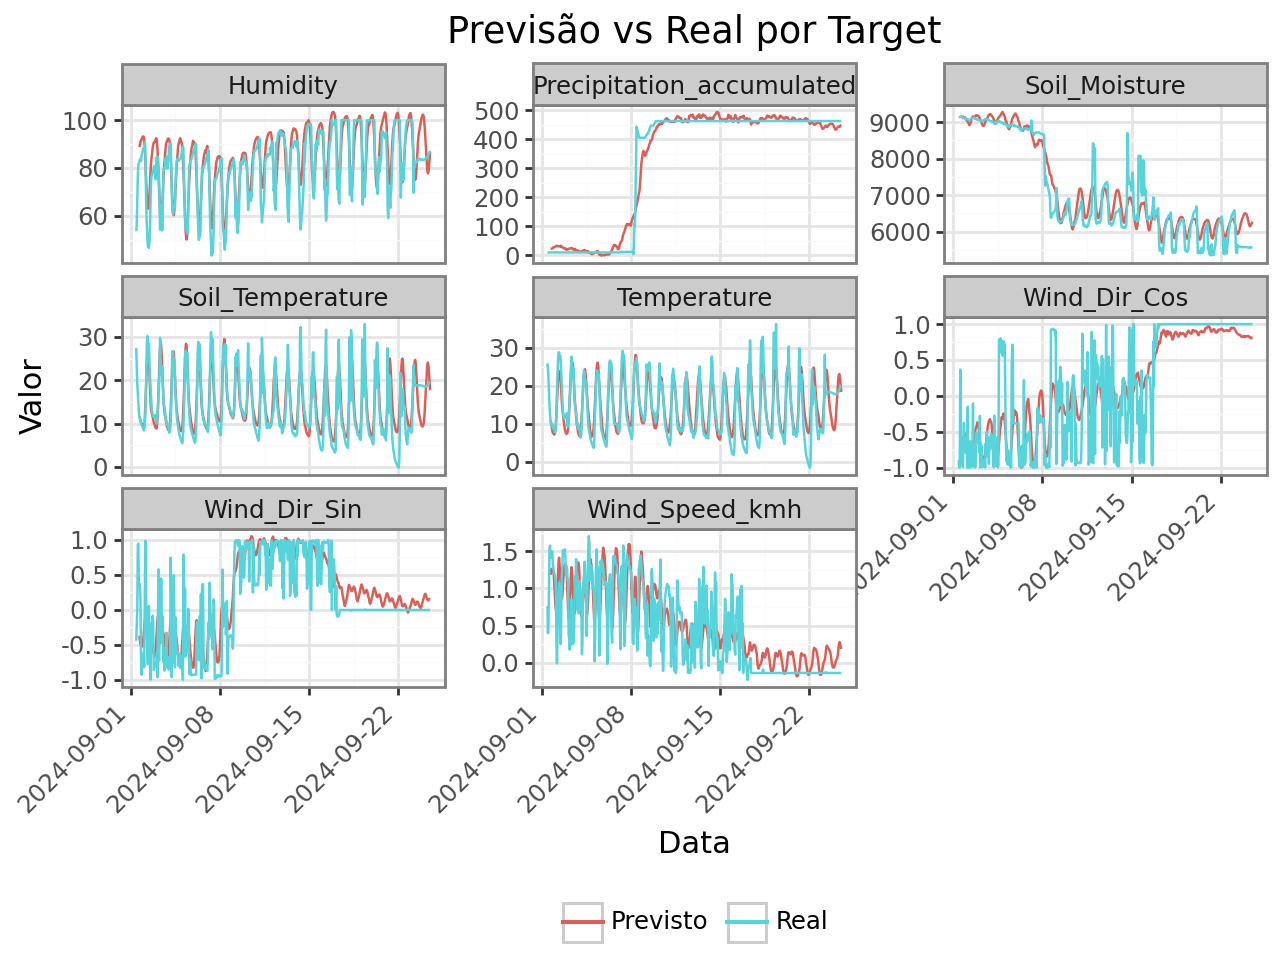

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

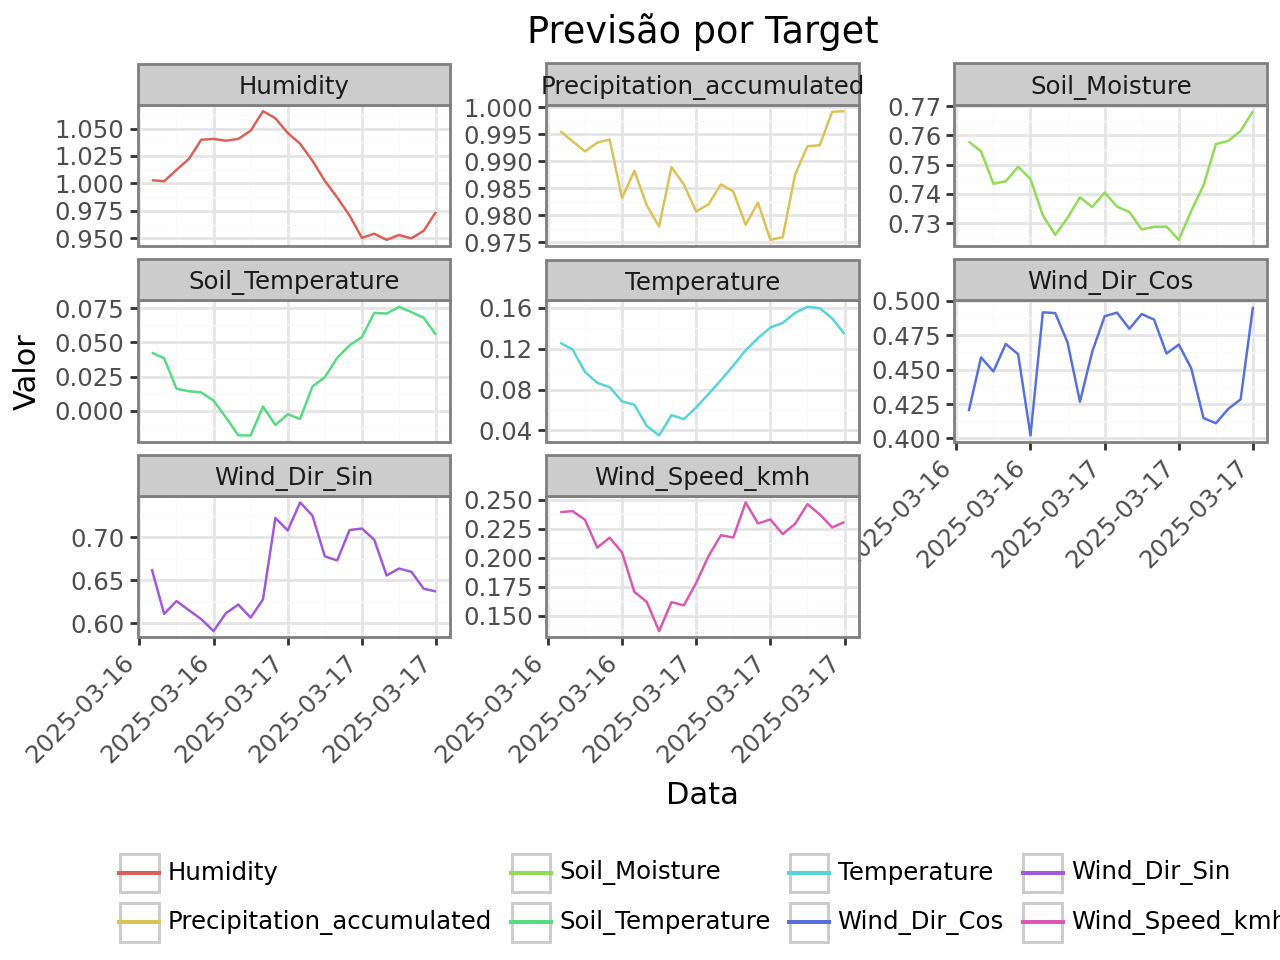

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

In [13]:
# prepara série-alvo e covariáveis
tgt_arr = best_val_scaled[0].values()
encoder_values = model.generate_fit_encodings(best_train_scaled)
cov_arr = encoder_values[0][0].values()  # use seu objeto de covariáveis reais

params = next(model.model.parameters())
dtype, device = params.dtype, params.device

tgt = torch.tensor(tgt_arr, dtype=dtype, device=device).unsqueeze(0)
cov = torch.tensor(cov_arr, dtype=dtype, device=device).unsqueeze(0)

full_input = torch.cat([tgt, cov], dim=2)
full_input.requires_grad_(True)
baseline = torch.zeros_like(full_input)

def forward_fn(x):
    preds,_ = model.model((x, None))
    return preds[:, -1, 0]

ig = IntegratedGradients(forward_fn)
attrs, delta = ig.attribute(
    inputs=full_input,
    baselines=baseline,
    return_convergence_delta=True
)
ig_vals = attrs.detach().cpu().numpy()[0].sum(axis=0)
print("IG importâncias:", ig_vals, "δ=", delta)

nt = NoiseTunnel(ig)
nt_attrs = nt.attribute(
    inputs=full_input,
    baselines=baseline,
    nt_type='smoothgrad',
    nt_samples=10,
    stdevs=0.02
)
nt_vals = nt_attrs.detach().cpu().numpy()[0].sum(axis=0)
print("NT importâncias:", nt_vals)


RuntimeError: shape '[50, 486, 1]' is invalid for input of size 900

In [36]:
target_names = best_val_scaled[0].columns.tolist()
covar_names  = encoder_values[0][0].columns.tolist()
feature_names = target_names + covar_names

# monta DataFrame
df = pd.DataFrame({
    "feature": feature_names,
    "IG": ig_vals,
    "NT": nt_vals,
}).melt(id_vars="feature", var_name="method", value_name="importance")

plot = (
    ggplot(df, aes(x="feature", y="importance", fill="method"))
    + geom_col(position="dodge")
    + coord_flip()                          # faz o flip para ficar horizontal
    + labs(x="Feature", y="Importância", fill="Método",
           title="Importância de Features pelo IG e NT")
    + theme_bw()
)

plot.show()
plot.save('importancia_features.png', width=12, height=10, dpi=300)

NameError: name 'ig_vals' is not defined